# Objective

Create a combined network of autoencoder and classifier to classify CIFAR10 data.

<hr></hr>

### Constraints
1. Use only 50% data of classes bird, deer and truck
2. Use output of encoder part of autoencoder as input of classifier

### Approach 
- Create a custom dataset which reads only 50% of bird, deer and truck, remaining classes 100%
- Create sampler which assignes weights to different classes to deal with imbalance dataset
- Use Image augmentation to inhance performance of classifire 
- Use stacked convolutional autoencoder to get most important features of input image
- Use convolutional neural network to classify images
- Use encoded output of autoencoder and use as input to CNN

<hr></hr>

In [50]:
import torch
import numpy as np
import torch.nn as nn
import torch.cuda as cuda
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.nn import functional as F

### Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

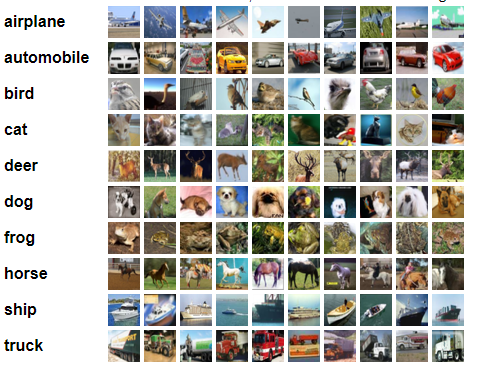

### Image augmentation

In [51]:
# transformation for validation data
transform_valid = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# transformation for training data
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.Resize((32,32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


### Custom dataset for filtering classes

In [52]:

class CifarCustomTrainDataset(Dataset):
    def __init__(self, transforms=None):
        '''
        Create a dataset with only 50% of bird, deer and truck classes, remaining classes with 100%
        '''
        self.transforms = transforms
        self.cifar10_train = datasets.CIFAR10('../data', train=True, download=True)
        self.truck_indices, self.deer_indices, self.bird_indices, self.other_indices = [], [], [], []
        truck_idx, deer_idx, bird_idx = self.cifar10_train.class_to_idx['truck'], self.cifar10_train.class_to_idx['deer'], self.cifar10_train.class_to_idx['bird']
        
        for i in range(len(self.cifar10_train)):
          current_class = self.cifar10_train[i][1]
          if current_class == truck_idx:
            self.truck_indices.append(i)
          elif current_class == deer_idx:
            self.deer_indices.append(i)
          elif current_class == bird_idx:
            self.bird_indices.append(i)
          else:
            self.other_indices.append(i)
    
        self.truck_indices = self.truck_indices[:int(0.5 * len(self.truck_indices))]
        self.deer_indices = self.deer_indices[:int(0.5 * len(self.deer_indices))]
        self.bird_indices = self.bird_indices[:int(0.5 * len(self.bird_indices))]
        self.cifar_10 = Subset(self.cifar10_train, self.truck_indices+self.deer_indices+self.bird_indices+self.other_indices)

    def __len__(self):
        return len(self.cifar_10)

    def __getitem__(self, idx):
        data = self.cifar_10[idx]
        if self.transforms is not None:
            data = (self.transforms(data[0]),data[1])
        return data 
    
    # image counter function for weight calculation
    def get_label(self, idx):
        data = self.cifar_10[idx]
        return data[1]
        

### training and validation dataset

In [53]:
valid_dataset = datasets.CIFAR10('../data', train=False, download=True, transform=transform_valid)
train_dataset = CifarCustomTrainDataset(transform_train)
print("train data size : ", len(train_dataset))
print("valid data size : ", len(valid_dataset))
print("truck size      : ", len(train_dataset.truck_indices))
print("deer size       : ", len(train_dataset.deer_indices))
print("bird size       : ", len(train_dataset.bird_indices))
print("other size      : ", len(train_dataset.other_indices))

Files already downloaded and verified
Files already downloaded and verified
train data size :  42500
valid data size :  10000
truck size      :  2500
deer size       :  2500
bird size       :  2500
other size      :  35000


### Data sampler to handle imbalance dataset

In [54]:

class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):        
        return dataset.get_label(idx)
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        

In [55]:
sampler = ImbalancedDatasetSampler(train_dataset)

**Some hyper parameters**

In [56]:
batch_size = 256
learning_rate = 0.0001
num_epochs = 120
weight_decay=1e-6

**Create the dataloader**

In [57]:
cifar10_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1, sampler=sampler)
cifar10_valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

**Utility to display the original and output image of autoencoder**

In [58]:
def show_img(orig, denoised):
    fig=plt.figure()
    
    orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    denoised = denoised.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 3, title='Denoised')
    plt.imshow(denoised)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()

### Classifier (CNN)

In [59]:
class CNN(nn.Module):
    def __init__(self):
      super().__init__()
                                                                          # 8 x 8 x 200 input
      self.conv1 = nn.Conv2d(200, 512, 3, 1, padding=1)                   # 8 x 8 x 300
      self.bn1 = nn.BatchNorm2d(512)
      self.do1 = nn.Dropout(0.5)
      self.mp1 = nn.MaxPool2d(2, stride=2)                              # 4 x 4 x 300
    
      self.conv2 = nn.Conv2d(512, 1024, 3, 1, padding=1)                   # 4 x 4 x 400
      self.bn2 = nn.BatchNorm2d(1024)
      self.do2 = nn.Dropout(0.5)
      self.mp2   = nn.MaxPool2d(2, stride=2)                              # 2 x 2 x 400
      
      self.fc3 = nn.Linear(2*2*1024, 512)
      self.bn3 = nn.BatchNorm1d(512)
      self.do3 = nn.Dropout(0.5)
    
      self.fc4 = nn.Linear(512, 512)
      self.bn4 = nn.BatchNorm1d(512)
      self.do4 = nn.Dropout(0.5)
    
      self.fc5 = nn.Linear(512, 256)
      self.bn5 = nn.BatchNorm1d(256)
      self.do5 = nn.Dropout(0.5)
      
      self.fc6 = nn.Linear(256, 10)
    
    def forward(self, x):
      x = self.mp1(self.do1(self.bn1(F.relu(self.conv1(x)))))
      x = self.mp2(self.do2(self.bn2(F.relu(self.conv2(x)))))
      
      x = x.view(-1, 2*2*1024)
        
      x = self.do3(self.bn3(F.relu(self.fc3(x))))
      x = self.do4(self.bn4(F.relu(self.fc4(x))))
      x = self.do5(self.bn5(F.relu(self.fc5(x))))
    
      x = self.fc6(x)
      return x

### Convolutional Autoencoder

In [60]:
class Autoencoder(nn.Module):
    
    def __init__(self):
    
        super(Autoencoder, self).__init__()
                                                                            # 32 x 32 x 3 (input)
        self.conv1 = nn.Conv2d(3, 100, 5, stride=1, padding=2)              # 32 x 32 x 100 
        self.bn1 = nn.BatchNorm2d(100)
        self.mp1e   = nn.MaxPool2d(2, stride=2, return_indices=True)        # 11 x 11 x 256
        self.conv2 = nn.Conv2d(100, 150, 5, stride=1, padding=2)            # 16 x 16 x 150 
        self.bn2 = nn.BatchNorm2d(150)
        self.mp2e   = nn.MaxPool2d(2, stride=2, return_indices=True)        # 16 x 16 x 150 
        self.conv3 = nn.Conv2d(150, 200, 3, stride=1, padding=1)            # 8 x 8 x 200
        
        self.conv4 = nn.ConvTranspose2d(200, 150, 3, stride=1, padding=1)   # 8 x 8 x 200
        self.mp1d = nn.MaxUnpool2d(2)                                       # 8 x 8 x 150
        self.bn3 = nn.BatchNorm2d(150)
        self.conv5 = nn.ConvTranspose2d(150, 100, 5, stride=1, padding=2)   # 16 x 16 x 150
        self.mp2d = nn.MaxUnpool2d(2)                                       # 16 x 16 x 100
        self.bn4 = nn.BatchNorm2d(100)
        self.conv6 = nn.ConvTranspose2d(100, 3, 5, stride=1, padding=2)   # 32 x 32 x 100 
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x, i_mp1e = self.mp1e(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x, i_mp2e = self.mp2e(x)
        
        features = self.conv3(x)
        
         # Decoder
        y = self.conv4(features)
        y = self.bn3(y)
        y = F.relu(y)
        y = self.mp1d(y, i_mp2e)
        
        y = self.conv5(y)
        y = self.bn4(y)
        y = F.relu(y)
        y = self.mp1d(y, i_mp1e)
        
        output = self.conv6(y)
      
        return features, output


**The Denoising Autoencoder**

In [61]:
autoencoder = Autoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)
autoencoder

Autoencoder(
  (conv1): Conv2d(3, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp1e): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp2e): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): ConvTranspose2d(200, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1d): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (bn3): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(150, 100, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (mp2d): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), paddin

In [62]:
cnn = CNN().cuda()
parameters_cnn = list(cnn.parameters())
loss_func_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(parameters_cnn, lr=learning_rate, weight_decay=weight_decay)
cnn

CNN(
  (conv1): Conv2d(200, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.5)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.5)
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc3): Linear(in_features=4096, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do3): Dropout(p=0.5)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do4): Dropout(p=0.5)
  (fc5): Linear(in_features=512, out_features=256, bias=True)
  (bn5): BatchNorm1d(256

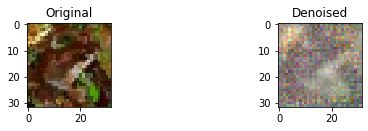

aen loss epoch [1/120], train:26.2164,  valid:2.7109
cnn loss epoch [1/120], train:2.1158,  valid:1.8799
cnn acc  epoch [1/120],                             train:21.31%, valid:31.68%
cnn acc  epoch [2/120],                             train:31.64%, valid:36.32%
cnn acc  epoch [3/120],                             train:37.94%, valid:40.25%
cnn acc  epoch [4/120],                             train:41.54%, valid:40.89%
cnn acc  epoch [5/120],                             train:43.77%, valid:43.12%
cnn acc  epoch [6/120],                             train:43.07%, valid:42.96%
cnn acc  epoch [7/120],                             train:45.82%, valid:44.98%
cnn acc  epoch [8/120],                             train:48.55%, valid:46.52%
cnn acc  epoch [9/120],                             train:49.48%, valid:49.29%
cnn acc  epoch [10/120],                             train:51.25%, valid:50.41%
cnn acc  epoch [11/120],                             train:52.97%, valid:50.70%
cnn acc  epoch [12/120],

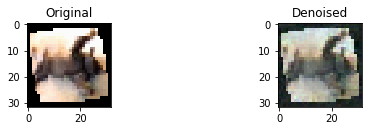

aen loss epoch [31/120], train:1.0418,  valid:0.2083
cnn loss epoch [31/120], train:1.0447,  valid:1.0753
cnn acc  epoch [31/120],                             train:63.43%, valid:64.26%
cnn acc  epoch [32/120],                             train:64.19%, valid:66.08%
cnn acc  epoch [33/120],                             train:64.49%, valid:66.00%
cnn acc  epoch [34/120],                             train:64.34%, valid:67.75%
cnn acc  epoch [35/120],                             train:65.11%, valid:65.96%
cnn acc  epoch [36/120],                             train:62.19%, valid:65.27%
cnn acc  epoch [37/120],                             train:63.48%, valid:62.12%
cnn acc  epoch [38/120],                             train:65.12%, valid:66.46%
cnn acc  epoch [39/120],                             train:65.74%, valid:66.47%
cnn acc  epoch [40/120],                             train:66.33%, valid:68.16%
cnn acc  epoch [41/120],                             train:66.93%, valid:68.18%
cnn acc  epoch

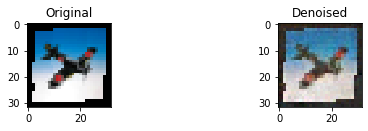

aen loss epoch [61/120], train:0.6943,  valid:0.2220
cnn loss epoch [61/120], train:0.7957,  valid:0.8553
cnn acc  epoch [61/120],                             train:72.68%, valid:71.48%
cnn acc  epoch [62/120],                             train:70.83%, valid:72.35%
cnn acc  epoch [63/120],                             train:72.32%, valid:73.29%
cnn acc  epoch [64/120],                             train:73.31%, valid:73.77%
cnn acc  epoch [65/120],                             train:73.26%, valid:74.10%
cnn acc  epoch [66/120],                             train:72.34%, valid:73.20%
cnn acc  epoch [67/120],                             train:73.29%, valid:73.15%
cnn acc  epoch [68/120],                             train:73.71%, valid:73.36%
cnn acc  epoch [69/120],                             train:73.47%, valid:73.84%
cnn acc  epoch [70/120],                             train:72.86%, valid:72.57%
cnn acc  epoch [71/120],                             train:72.36%, valid:73.35%
cnn acc  epoch

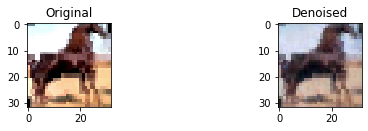

aen loss epoch [91/120], train:0.5404,  valid:0.1157
cnn loss epoch [91/120], train:0.6943,  valid:0.7406
cnn acc  epoch [91/120],                             train:76.78%, valid:75.82%
cnn acc  epoch [92/120],                             train:77.19%, valid:75.78%
cnn acc  epoch [93/120],                             train:76.68%, valid:76.68%
cnn acc  epoch [94/120],                             train:77.11%, valid:75.75%
cnn acc  epoch [95/120],                             train:77.44%, valid:76.97%
cnn acc  epoch [96/120],                             train:77.76%, valid:76.96%
cnn acc  epoch [97/120],                             train:77.34%, valid:76.07%
cnn acc  epoch [98/120],                             train:77.38%, valid:76.52%
cnn acc  epoch [99/120],                             train:78.07%, valid:77.38%
cnn acc  epoch [100/120],                             train:77.96%, valid:76.47%
cnn acc  epoch [101/120],                             train:77.79%, valid:75.05%
cnn acc  epo

limit_output extension: Maximum message size of 10000 exceeded with 10035 characters

In [63]:
train_loss_aen = []
valid_loss_aen = []
train_loss_cnn = []
valid_loss_cnn = []
train_acc_cnn = []
valid_acc_cnn = []

for epoch in range(num_epochs):
    
    # Let's train the model
    epoch_train_loss_aen = 0.0
    epoch_train_loss_cnn = 0.0
    epoch_train_iter = 0
    
    epoch_val_loss_aen = 0.0
    epoch_val_loss_cnn = 0.0
    epoch_val_iter = 0
    
    running_train_corrects_cnn = 0.0
    running_val_corrects_cnn = 0.0
    
    total_train = 0
    total_val = 0
    
    autoencoder.train()
    cnn.train()
    
    for image, label in cifar10_train_loader:
        
        #print(label.size(0))

        # autoencoder training
        image = Variable(image).cuda()
        optimizer.zero_grad()
        encoder_output, output = autoencoder(image)
        
        loss_aen = loss_func(output, image)
        loss_aen.backward()
        optimizer.step()
        
        total_train += label.size(0)
        epoch_train_iter += 1
        epoch_train_loss_aen += loss_aen.data.item()
        
        # cnn training
        encoder_output = Variable(encoder_output).cuda()
        optimizer_cnn.zero_grad()
        output_cnn = cnn(encoder_output)
        
        label = Variable(label).cuda()
        loss_cnn = loss_func_cnn(output_cnn, label)
        loss_cnn.backward()
        optimizer_cnn.step()
        
        _, preds = torch.max(output_cnn, 1)
        running_train_corrects_cnn += torch.sum(preds == label.data)
        
        epoch_train_loss_cnn += loss_cnn.data.item()
            
    # Let's visualize the first image of the last batch in our validation set
    if epoch % 30 == 0:
        original = image[0].cpu()
        decoded = output[0].cpu()

        original = original.data.numpy()
        decoded = decoded.data.numpy()

        show_img(original, decoded)
        
    autoencoder.eval()
    cnn.eval()
    
    for image, label in cifar10_valid_loader:
        
        image = Variable(image).cuda()
        
        encoder_output, output = autoencoder(image)
        loss = loss_func(output, image)
        
        total_val += label.size(0)
        epoch_val_iter += 1
        epoch_val_loss_aen += loss.data.item()
        
        # cnn training
        encoder_output = Variable(encoder_output).cuda()
        output_cnn = cnn(encoder_output)
        label = Variable(label).cuda()
        
        _, preds = torch.max(output_cnn, 1)
        running_val_corrects_cnn += torch.sum(preds == label.data)
                
        loss_cnn = loss_func_cnn(output_cnn, label)
        
        epoch_val_loss_cnn += loss_cnn.data.item()
           
    if epoch % 30 == 0:
        print('aen loss epoch [{}/{}], train:{:.4f},  valid:{:.4f}'.format(epoch+1, num_epochs, epoch_train_loss_aen, epoch_val_loss_aen))
        print('cnn loss epoch [{}/{}], train:{:.4f},  valid:{:.4f}'.format(epoch+1, num_epochs, epoch_train_loss_cnn/epoch_train_iter, epoch_val_loss_cnn/epoch_val_iter))
    print('cnn acc  epoch [{}/{}],                             train:{:.2f}%, valid:{:.2f}%'.format(epoch+1, num_epochs, running_train_corrects_cnn.float()/total_train*100, running_val_corrects_cnn.float()/total_val*100))    

    train_loss_aen.append(epoch_train_loss_aen / epoch_train_iter)
    valid_loss_aen.append(epoch_val_loss_aen / epoch_val_iter)
    train_loss_cnn.append(epoch_train_loss_cnn / epoch_train_iter)
    valid_loss_cnn.append(epoch_val_loss_cnn / epoch_val_iter)
    train_acc_cnn.append(running_train_corrects_cnn.float()/total_train*100)
    valid_acc_cnn.append(running_val_corrects_cnn.float()/total_val*100)
    

In [64]:
# Save the model
#torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")

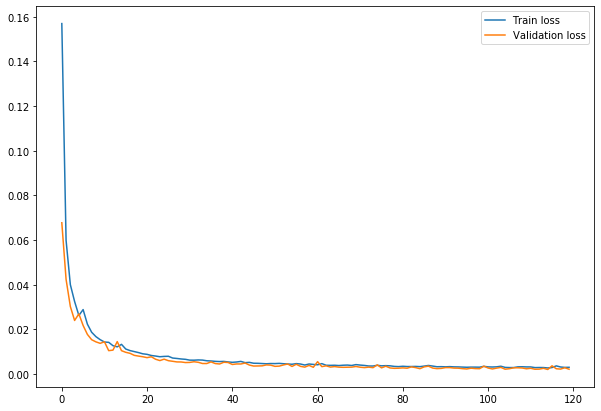

In [65]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss_aen, label='Train loss')
plt.plot(valid_loss_aen, label='Validation loss')
plt.legend()
plt.show()

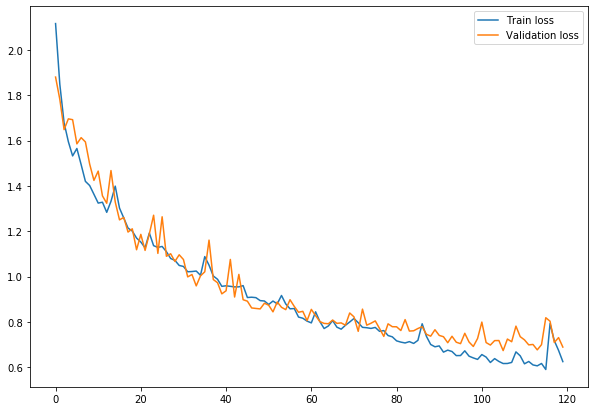

In [66]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss_cnn, label='Train loss')
plt.plot(valid_loss_cnn, label='Validation loss')
plt.legend()
plt.show()

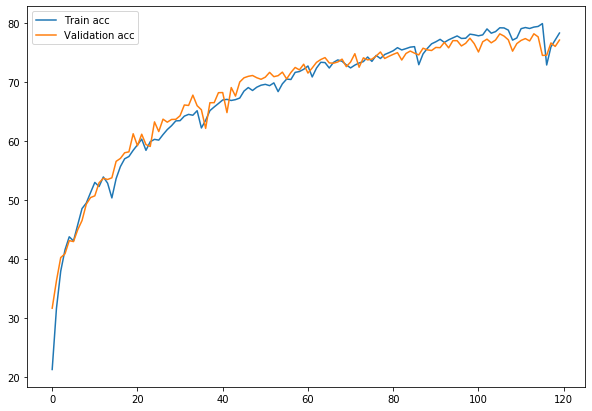

In [67]:
fig = plt.figure(figsize=(10, 7))
plt.plot(train_acc_cnn, label='Train acc')
plt.plot(valid_acc_cnn, label='Validation acc')
plt.legend()
plt.show()

## Observation:
By seeing accuracy and We can clearly see 

### Let's do standalone inference

In [68]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [69]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

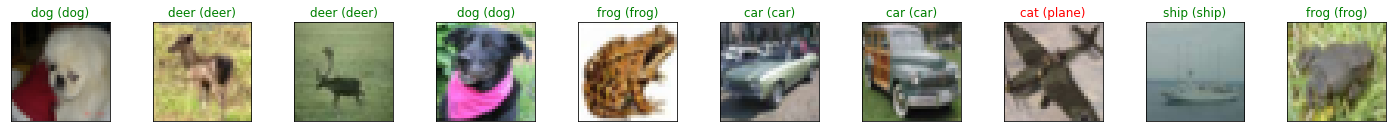

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataiter = iter(cifar10_valid_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

encoder_output, denoised = autoencoder(images)
encoder_output = encoder_output.to(device)

label = cnn(encoder_output)

_, preds = torch.max(label, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))